<a href="https://colab.research.google.com/github/RachelRamirez/tta/blob/main/TTA_experiments_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparison of 4 Probabilistics Techniques** 

Traditional CNN (baseline),  2 "Bayesian" CNNs, and Test-Time Augmentations on CIFAR-9 classes and one novel class

# Cifar10 classification case study with novel class


# Intro

#### Load Neptune to Track Experiments

In [88]:
pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This is a resource originally about Bayesian Neural Networks,  by TensorChiefs found as supplemental coding material for their book [Probabilistic Deep Learning](https://tensorchiefs.github.io/dl_book/), their original code is [here](https://colab.research.google.com/drive/1ZCNuGd9z_ZvJ7irFH-FQmqlFXP5jeK8z#scrollTo=TNFhkloWTImi). **I  added  Test Time Augmentation.**

Future: I plan to add [time and memory run profiles](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=HdeOK7Qhw0wp) to also compare the methods

In [89]:
#@title Just do TTA experiments? { display-mode: "form" }
#@markdown This Colab will skip everything but TTA if checked
just_TTA  = True #@param {type: "boolean"} 

if just_TTA:
  print("Will skip everything but TTA experiments")

Will skip everything but TTA experiments



**Goal:** In this notebook you will investigate which advantages Bayesian NNs can offer in a classification task. You will use train data from 9 of the 10 classes in the Cifar10 dataset to fit different three probabilistic NN.
First you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via dropout. You will compare the accuracy of the different NN on the 9 known classes. Further you will investigate and compare the uncertainties expressed by the NNs for both the known classes and unknown class. Finally you will use these uncertainties to detect novel classes and filter out uncertain predictions.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"). You will delete all images from the class "horse" in the training dataset to simulate a novel class. Note that we keep the class "horse" in the test dataset.

**Content:**
* Load the Cifar10 dataset
* Delete all images of the class "horse" from the training dataset
* Split the train dataset into a train and validation dataset (60:40 split) 
* Fit a non-Bayesian NN 
* Fit a Bayesian NN via variational inference 
* Fit a Bayesian NN via dropout 
* Compare the  of the accuracy of the models on the known classes
* Compare the  of the uncertainties of the models on the known and unknown classes
* Use the uncertainties to filter uncertain predictions

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_04.ipynb)

In [90]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [91]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.9.2  running in colab?:  True


In [92]:
# I commented this out because I think there are too many outdated dependencies

# if IN_COLAB:
#     !pip install tensorflow_probability==0.8.0

#### Imports

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split

#I added this below from StackOverflow to see if it wouldsolve import issues
#https://stackoverflow.com/questions/62743492/cannot-import-tensorflow-probability
# !pip install --upgrade tf_agents

import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

## Adding Test time Augmentation TTA
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix




import datetime, time

!pip install memory_profiler

%load_ext memory_profiler



from IPython.display import clear_output 



clear_output()

In [94]:

begin = datetime.datetime.now()

# now.strftime('%Y-%m-%d %H:%M:%S')

print(begin)


2023-01-19 16:44:33.707133


In the next cell you disable the tensorflow eager mode. We need to do this because otherwise we would get errors for the variational inference NN and we  would not be able to turn on and off the dropout in the MC dropout NN.

In [95]:
if just_TTA:
  print("Not disabling eager execution mode because just doing TTA")
else:
    from tensorflow.python.framework.ops import disable_eager_execution
    disable_eager_execution()

Not disabling eager execution mode because just doing TTA


#### Loading and preparation of the dataset

Let's load the cifar 10 dataset. It is already splited into a train and test dataset. To get a feeling for the dataset, you plot a random example of each class of the trainingset. You can see that the images are quite small and its not always easy to see the class on the image.

In [96]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

<ipython-input-97-012e5f5aa791>:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)


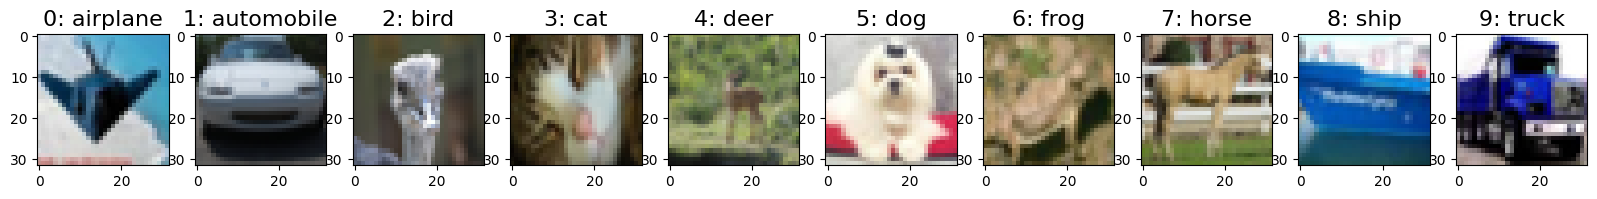

In [97]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)
plt.savefig("Figure_8_cifar.pdf")
#from google.colab import files
#files.download('Figure_8_cifar.pdf') 


To simualte a novel class, you will delete all images of the class "horse" from the traning dataset. Note that you do this only in the trainset, the test dataset stays the same. In the train dataset you will now have 9 classes with 5'000 images of every class, in total 45'000 images. This will be your traning dataset for the three models.   

In [98]:
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
print(y_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)
(45000, 9)


Now you split the new training dataset without the horses randomly into a train and validationset. You use a 60:40 ratio for the split, so you have 27'000 train images with 9 classes and 18'000 validation images with 9 classes. The test dataset has 10'000 images and 10 classes. Note that we have a novel (unknown) class "horse" in the testset.

In [99]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)
#  print(x_train.shape)
#  print(y_train.shape)
#  print(x_val.shape)
#  print(y_val.shape)
#  print(x_test.shape)
#  print(y_test.shape)



x_test, x_holdout, y_test, y_holdout = train_test_split(x_test, y_test, test_size=0.1, random_state=22)
print("X train:",  x_train.shape)
print("Y train:",  y_train.shape)
print("X Val:",   x_val.shape)
print("Y Val:",   y_val.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("X Test:",  x_test.shape)
print("Y Test:",  y_test.shape)
print("X Holdout:", x_holdout.shape)
print("Y Holdout:", y_holdout.shape)



#Before training the NNs with the data, we normalize the data to be in the range between -1 and 1. 
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2
x_holdout=((x_holdout/255)-0.5)*2
x_test.min(), x_test.max()

X train: (27000, 32, 32, 3)
Y train: (27000, 9)
X Val: (18000, 32, 32, 3)
Y Val: (18000, 9)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test: (9000, 32, 32, 3)
Y Test: (9000, 1)
X Holdout: (1000, 32, 32, 3)
Y Holdout: (1000, 1)


(-1.0, 1.0)

In [100]:
# #Experiment to bring it back to 0 and 255
# x_test_exp=((x_test/2)+0.5)*255
# x_test_exp.min(), x_test_exp.max()

# Experiment with experument to bring it to 0 and 1.
def revertscale_fn(img):
    img = img.astype(np.float32) / 2
    img = (img + 0.5) * 255
    return img
# gen = ImageDataGenerator(
#     preprocessing_function=revertscale_fn,
#     rescale = 1./255,
# )

## Non-Bayesian CNN

In this section we use a CNN with two convolutional blocks, followed by maxpooling layers. You use 8 kernels with the size 3x3 in the first convolutional block and in the second block you use 16 kernels with the size 3x3. The maxpoolingsize is 2x2 pixels. After the feature extraction you use a flatten layer and do the classification with 3 fully connected layers. Because the training takes a lot of time, you will load an already trained CNN with the learning curve.

In [101]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                  

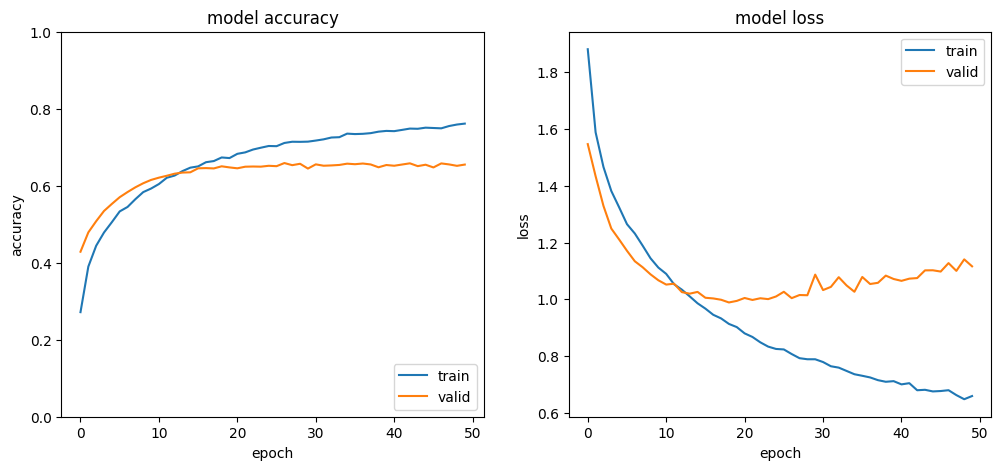

In [102]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_baseline_cifar10.csv", "history_baseline_cifar10.csv")
history=np.loadtxt("history_baseline_cifar10.csv",delimiter=",")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [103]:
# load trained weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_cifar10_weights.hdf5", "model_cifar10_weights.hdf5")
model.load_weights("model_cifar10_weights.hdf5")

I didn't know if the model was trained using EarlyStop or Val_Loss, I just see that the previous model was trained on accuracy so I want to train the model and double check that it was stopped around epoch 20 and not epoch 50 where the validation loss increased.  (ETA - Verified it was epoch 20)



In [104]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)
# history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=50, verbose='0', callbacks = [callback], validation_data=(x_val, y_val))
# history = history.history

In [105]:
# First of all call dict. items() to return a group of the key-value pairs in the dictionary.
# Then use list(obj) with this group as an object to convert it to a list.
# At last, call numpy. array(data) with this list as data to convert it to an array.
 

In [106]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(history['accuracy'])
# plt.plot(history['val_accuracy'])
# plt.ylim(0, 1)
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='lower right')
# plt.subplot(1,2,2)
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper right')
# plt.show()

Here you save the indices of the known and the unknown (horse) classes. You will use them later to evaluate the uncertainty measures.

In [107]:
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]

print(len(known_idx))
print(len(unknown_idx))

8085
915


what is the given acuracy on the train and **val** set?

In [108]:
# pred=model.predict(x_val)  #array (18000, 9)
# pred_max_p=np.max(pred,axis=1) #array of (18000,)

# entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
# nll_=-np.log(pred_max_p)
# pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
# true_labels=np.array([labels_no_horse[np.argmax(y_val[i])] for i in range(0,len(y_val))])
# val_cm = confusion_matrix(true_labels, pred_labels)

# disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=labels_no_horse)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()


# val_acc_all=np.average(true_labels==pred_labels)
# val_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
# val_acc_all, val_acc_known


## Accuracy on the the known labels in the train set for all three models 
In this section you will calculate the accuracies and of all three models. For the non bayesian NN, you will predict every test image once and for the two bayesian NN, you will predict every image 50 times and then takes the mean of all predicted classes. 





#### Non-Bayesian prediction

Here you predict the labels for the non-bayesian CNN and calculate the uncertainty measures. You calculate the nll and the entropy, note that there is no total standart deviation in the non-bayesian model, because the same image will always get the same prediction. This is also the reason why we don't need to predict the same image for multiple times.

In [109]:
# This is how you get accuracy from the Baseline Vanilla CNN. These predictions only work for deterministic sources

# pred=model.predict(x_test)
# pred_max_p=np.max(pred,axis=1)
# entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
# nll=-np.log(pred_max_p)
# pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
# true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])

# test_acc_all=np.average(true_labels==pred_labels)
# test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
# test_acc_all, test_acc_known

In [110]:
pred=model.predict(x_test)
pred_max_p=np.max(pred,axis=1)
entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
nll=-np.log(pred_max_p)
pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])
 

282/282 [==============================] - 1s 2ms/step


Confusion Matrix for Test-Data from Vanilla-CNN Model (no TTA)

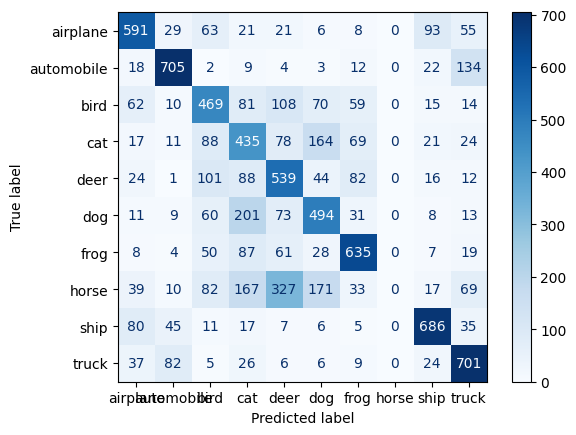

In [111]:
 
cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [112]:

test_acc_all=np.average(true_labels==pred_labels)
test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
test_acc_all, test_acc_known

correct_idx_basic = np.where(true_labels==pred_labels)
incorrect_idx_basic = np.where(true_labels!=pred_labels)

The non-bayesian CNN scores 58.45% accuracy on all 10 items, because it misidentified horse (it can't possibly classify it correctly), but it scored 64.9% accuracy on the remaining categories.

# New

I want to restart my runs here, so I don't have to reload everything (data, history of model training, imports) so what I need to do is Delete Variables created from the previous run.

#### 🆕 Test Time Augmentation

Here I predict the labels for the traditional CNN with Test Time Augmentation and possibly calculate the uncertainty measures.  I predict the same image for 50 times and calculate the mean predicted probabilities, the nll, the entropy, and total standard deviations. 

##### Delete_Old_Parameters (to try and save memory on google colab)

In [113]:
def delete_old_params():
  global  entropy_tta, nll_tta,   final_pred,  pred_std_tta,  test_datagen

  del(   entropy_tta, nll_tta,   final_pred,  pred_std_tta,  test_datagen)

# try: 
#   list_of_vars =  [params, run,  test_datagen, tta_steps, bs, display_datagen, preds, predictions_tta, cm_tta,  entropy_tta, nll_tta, pred_labels_tta, df,
#       test_acc_all_tta, final_pred, pred_tta, pred_max_p_tta, pred_std_tta, pred_tta_mean_max_p,
#   predictions_tta_idx, final_pred_idx, disp_tta, X_batch, y_batch]
# except NameError:
#   list_of_vars =  [params, run,  test_datagen, tta_steps, bs, display_datagen, preds, predictions_tta, cm_tta,  entropy_tta, nll_tta, pred_labels_tta, df,
#       test_acc_all_tta, final_pred, pred_tta, pred_max_p_tta, pred_std_tta, pred_tta_mean_max_p,
#   predictions_tta_idx, final_pred_idx, disp_tta, X_batch, y_batch]

# for i in list_of_vars:
#   try:  
#     i
#   except NameError:
#    del(i)


In [114]:
start = datetime.datetime.now()
print(start)

2023-01-19 16:44:38.863597


Define the Test Time Image Generator

Keras has predefined choices of [augmentations defined here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) and explained visually well [here](https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844) in a TowardsDataScience Medium Blog Post 

In [115]:
import neptune.new as neptune
from neptune.new.types import File


##### def new_run()

In [116]:
# Initialize a New Neptune Run function - takes no input yet? #returns a run
def new_run(tag):
    run = neptune.init(
      project="rachel.ramirez2006/RotationsOnly",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NWZjMGEyYy1mZGI3LTQ1NWMtOGUyZi0wODc2OWI2OGU3NzcifQ==",)  # your credentials
    run["sys/tags"].add([tag])  
    return run


In [117]:
tta_steps = 50
bs = 64
# epochs = 15

There are the original tried test_datagen that have resulted in the highest accuracy scores:

        tta_steps = 50,
        bs = 64,
        
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

##### def make_init_params(tta_steps=50, bs=64, low_rotation=0, high_rotation=10,  fill_mode = 'reflect'):

In [118]:
def make_init_params(tta_steps=50, bs=64, low_rotation=0, high_rotation=10, horizontal_flip = True,  fill_mode = 'reflect'):
  params = {
        'tta_steps': tta_steps,
        'bs': bs,
         'low_rotation': low_rotation,
         'high_rotation': high_rotation,  
          # 'rotation_range': 5, 
          # 'shear_range': 5,
          # 'zoom_range' : 0.1,
          'horizontal_flip': horizontal_flip, 
          # 'width_shift_range' : 0.1,
          # 'height_shift_range' : 0.1 ,

          # 'brightness_range' : (0.9,1.1),
          # 'channel_shift_range': 45/255,
          'fill_mode' : fill_mode,
          # 'featurewise_center': False,
          # 'samplewise_center': False,
          # 'featurewise_std_normalization': False,
          # 'samplewise_std_normalization' : False,
          # 'zca_whitening' : False,


            # 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
            # 'nearest': aaaaaaaa|abcd|dddddddd
            # 'reflect': abcddcba|abcd|dcbaabcd
            # 'wrap': abcdabcd|abcd|abcdabcd
            # cval	Float or Int. Value used for points outside the boundaries when fill_mode = "constant".
        # 'vertical_flip': False
        }
  return params





##### def make_image_data_generator():


In [119]:
def make_image_data_generator(params):
  #takes a dictionary of parameters 
  #makes display_datagen to display augmentations on a batch
  #saves display to run
  #returns test_datagen

  test_datagen = ImageDataGenerator(
          #preprocessing_function=revertscale_fn,   #hoping this will increase the overall accuracy of TTA from 0.448 to something more similar to the vanilla CNN without TTA - IT DID NOT
          #rescale = 1./255,
          # shear_range=params['shear_range'],
          # zoom_range=params['zoom_range'],
          # horizontal_flip=params['horizontal_flip'],
          rotation_range= params['high_rotation'],
          fill_mode=params['fill_mode'] ,
        #   width_shift_range = params['width_shift_range'], 
        #   height_shift_range = params['height_shift_range'],

        #  featurewise_center = params['featurewise_center'],
        #  samplewise_center  = params['samplewise_center'],
        #  featurewise_std_normalization = params['featurewise_std_normalization'],
        #  samplewise_std_normalization = params['samplewise_std_normalization'],

        #   zca_whitening = params['zca_whitening'],

        #   brightness_range = params['brightness_range'],
  
          # channel_shift_range = params['channel_shift_range'],
          # vertical_flip = params['vertical_flip']
          )

  display_datagen = ImageDataGenerator(
          preprocessing_function=revertscale_fn,   #yay that worked
          rescale = 1./255,
            # shear_range=params['shear_range'],
            # zoom_range=params['zoom_range'],
            # horizontal_flip=params['horizontal_flip'],
            rotation_range= params['high_rotation'],
            fill_mode=params['fill_mode'] ,
          #   width_shift_range = params['width_shift_range'], 
          #   height_shift_range = params['height_shift_range'],

          #  featurewise_center = params['featurewise_center'],
          #  samplewise_center  = params['samplewise_center'],
          #  featurewise_std_normalization = params['featurewise_std_normalization'],
          #  samplewise_std_normalization = params['samplewise_std_normalization'],

          #   zca_whitening = params['zca_whitening'],

          #   brightness_range = params['brightness_range'],
    
          #   channel_shift_range = params['channel_shift_range'],
          #   vertical_flip = params['vertical_flip'],
    )

  display_datagen.fit(x_train)

  tta_plt = plt.figure(figsize=(5,3)) #I want to name this plot so I can save it in Neptune.

  for X_batch, y_batch in display_datagen.flow(x_train, y_train, batch_size=15):
      for i in range(0, 15):
          plt.subplot(3, 5, i+1)
          plt.imshow(X_batch[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
          plt.axis('off')
      plt.tight_layout(pad=0.1)
      plt.show()
      break

  run["tta_image_preview"].upload(tta_plt)   #I want to save this plot in Neptune.
  # run["tta_image_preview-interactive"].upload(File.as_html(tta_plt)) #doesnt work

  return test_datagen


##### def make_predictions_with_tta():


In [120]:
def make_predictions_with_tta():
  #takes test_datagen, model, and x_test, tta_steps
  #returns final_pred the mean of all tta_steps
  # predictions_tta_array = np.empty((10000,9))
  predictions_tta = []
  #predictions_tta_df =  pd.DataFrame([])
  test_datagen.fit(x_train)

  #for i in tqdm(range(tta_steps)):
  for i in tqdm(range(5)):
      preds = model.predict(test_datagen.flow(x_test, batch_size=bs, shuffle=False), steps = len(x_test)/bs, verbose=0)   #Changed X_val to X_test 
      # print("Iteration i: ", i, " Preds Shape is ", preds.shape)
      # preds.resize((1, 10000, 9))
      predictions_tta.append(preds)
  
  final_pred = np.mean(predictions_tta, axis=0)
 

  return final_pred

In [121]:
# predictions_tta[0][0]   #the first guess of #tta_steps for the 0th image, 1st prob guess is "3" followed by "5"
# predictions_tta[9][0]   #the 9th   guess of #tta_steps for the 0th image, 1st largest prob is "3" followed by "5"
# y_test[0]               #the actual label of the 0th test image is "3" so it would have got this correct.

In [122]:
# Size of things
#final_pred         # An array of 10000x9 10000 images with 9 classes of probabilities
#predictions_tta    # A list of TTA_#_OF_Steps of  10000 images with 9 classes of probabilities

##### def calc_metrics()

In [123]:
# final_pred
def calc_metrics():
  #takes x_test predictions and truth and calculates metrics like max p, std def, entropy
  # returns run information for Neptune
  pred_tta=np.zeros((len(x_test),9))
  pred_max_p_tta=np.zeros((len(x_test)))
  pred_std_tta=np.zeros((len(x_test)))
  entropy_tta = np.zeros((len(x_test)))


  for i in tqdm(range(0,len(x_test))):
    #multi_img=np.tile(x_test[i],(50,1,1,1))
    #preds=model_mc_pred([multi_img,1])
    pred_tta[i]= final_pred[i]

    pred_max_p_tta[i]=np.argmax(final_pred[i]) #mean over n runs of every proba class
    pred_std_tta[i]= np.sqrt(np.sum(np.var(final_pred[i])))
    entropy_tta[i] = -np.sum( pred_tta[i] * np.log2(pred_tta[i] + 1E-14)) #Numerical Stability


  # print("Image 1 Pred TTA  is ")
  # print(pred_tta[1])
  # print("Image 1 Pred Max P TTA  is ")
  # print(pred_max_p_tta[1])
  # print("Image 1 Entropy is ")
  # print(entropy_tta[1])

    

  pred_labels_tta=np.array([labels_no_horse[np.argmax(pred_tta[i])] for i in range(0,len(pred_tta))])
  pred_tta_mean_max_p=np.array([pred_tta[i][np.argmax(pred_tta[i])] for i in range(0,len(pred_tta))])
  nll_tta=-np.log(pred_tta_mean_max_p)


  # print("Image 1's Pred Labels TTA is ")
  # print(pred_labels_tta[1]) 
  # print("Image 1's Pred_TTA_MEAN_MAX_P is ")
  # print(pred_tta_mean_max_p[1])
  # print("Image 1's NLL is  ")
  # print(nll_tta[1])


  test_acc_all_tta=np.average(true_labels==pred_labels_tta)
  test_acc_known_tta=np.average(true_labels[known_idx]==pred_labels_tta[known_idx])
  print(test_acc_all_tta, test_acc_known_tta)
  run["test_acc_all_tta"] = test_acc_all_tta
  run["test_acc_known_tta"] = test_acc_known_tta
  run["pred_std_tta"] = pred_std_tta
  run["pred_labels_tta"] = pred_labels_tta
  run["nll_tta"] = nll_tta
  # run["nll_tta_log"].log(nll_tta)  #"value of type numpy.ndarray is not supported please use file.as_image()"

  run["entropy_tta"] = entropy_tta
  run["pred_max_p_tta"] = pred_max_p_tta




  cm_tta = confusion_matrix(true_labels, pred_labels_tta)
  disp_tta = ConfusionMatrixDisplay(confusion_matrix=cm_tta, display_labels=labels)
  disp_tta.plot(cmap=plt.cm.Blues)
  # plt.show()
  plt.savefig("cm_tta.png") #save as png
  run["test_cm_tta"] = cm_tta
  run["test_cm_tta_pic"].upload("cm_tta.png")
  
  # run['predictions_tta_dataframe'] = df

 
  df = pd.DataFrame(data={'y_test': y_test.reshape(-1), 'y_pred': final_pred.argmax(axis=1), 'y_pred_probability': final_pred.max(axis=1), 'entropy': np.round(entropy_tta, 3) })


  df = df.assign(Test_Labels = lambda df: labels[df.y_test])
  df = df.assign(Pred_Labels = lambda df: labels_no_horse[df.y_pred])
  df = df.assign(Result=lambda df: df.Test_Labels==df.Pred_Labels)
  df['Result'].value_counts()
  correct_idx   = df[df["Result"]==True].index.values
  incorrect_idx = df[df["Result"]==False].index.values


  # ---
  #I want to save the Index values of the Correctly Classified images


  # --- 
  
  #run['Table_Of_Mean_TTA_Test_Predictions'] = neptune.types.File.as_html(df)
  
  df.to_csv('df.csv', sep = ',')
  variable_name = "CSV_" + str(rot_degree)
  run[variable_name].upload("df.csv")  

  return nll_tta, pred_std_tta, entropy_tta, correct_idx, incorrect_idx

If I need help reviewing what variables are taking up a lot of space this is the code to use.  I believe Test_Gen is one of the largest.

In [ ]:
# # A bit more code, but works in Python 3 and gives a sorted, human readable output:
# # from https://stackoverflow.com/questions/24455615/python-how-to-display-size-of-all-variables

# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1]):
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

Sometimes Console Output is the culprit for exceeding RAM.  Therefore I use clear_output to clear the console logs and displays after each run.  I don't view this stuff anymore anyway, it is stored to Neptune so I can reference if needed.

In [ ]:
# # https://stackoverflow.com/questions/60127913/how-to-clear-the-output-in-google-colab-via-code


# from IPython.display import clear_output 



# clear_output()

##### def run the program

peak memory: 18646.40 MiB, increment: 0.00 MiB
peak memory: 18646.40 MiB, increment: 0.00 MiB
https://app.neptune.ai/rachel.ramirez2006/RotationsOnly/e/ROT-398
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
peak memory: 18646.43 MiB, increment: 0.03 MiB
10
peak memory: 18646.45 MiB, increment: 0.00 MiB
peak memory: 18646.45 MiB, increment: 0.00 MiB


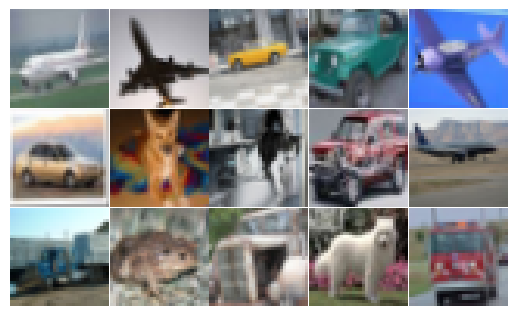

peak memory: 19279.91 MiB, increment: 633.46 MiB


<ipython-input-120-b0125521a77a>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# For-Loop  i = 1 through 5

# Define a Run Function
 

# create a dictionary of  parameters to pass to data_generator
for rot_degree in range(0,20,2):

  tta_steps = 10

  
  %memit run = new_run("flip_horizontal-true")

  print(rot_degree)


  %memit init_params = make_init_params(tta_steps, high_rotation=rot_degree)  # I need an inbetween var bc when run.stop runs the run[parameters] var disappears 

  %memit run["parameters"]  = init_params

  %memit test_datagen = make_image_data_generator(init_params)

  # save predictions
  %memit final_pred = make_predictions_with_tta()
  %memit nll_tta, pred_std_tta, entropy_tta, correct_idx, incorrect_idx  = calc_metrics()

  # delete_old_params()


      
  def plot_hists_basic(dist, title, xlabel, xlim=None):
      plt.hist(dist[unknown_idx],bins=30, density=True,alpha = 0.5)
      plt.hist(dist[incorrect_idx_basic],bins=30,  density=True,alpha = 0.5)
      plt.hist(dist[correct_idx_basic],bins=30,  density=True,alpha = 0.5)
      plt.title(title)
      plt.legend(['unknown', 'known_incorrect', 'known_correct'])
      plt.xlabel(xlabel)
      if xlim != None:
          plt.xlim(xlim)
   

  def plot_hists(dist, title, xlabel, xlim=None):
      plt.hist(dist[unknown_idx],bins=30, density=True,alpha = 0.5)
      plt.hist(dist[incorrect_idx],bins=30,  density=True,alpha = 0.5)
      plt.hist(dist[correct_idx],bins=30,  density=True,alpha = 0.5)
      
      plt.title(title)
      plt.legend(['unknown', 'known_incorrect', 'known_correct'])
      plt.xlabel(xlabel)
      if xlim != None:
          plt.xlim(xlim)

  plt.figure(figsize=(12,12))

  # Non-Bayesian
  plt.subplot(4,3,1)
  plot_hists_basic(nll, "Non-Bayesian nll of max p", "NLL", [-0.2,2])
  plt.subplot(4,3,2)
  plt.axis("off")
  plt.subplot(4,3,3)
  plot_hists_basic(entropy, "Non-Bayesian entropy", "Entropy", [-0.2,3.2])

 


  # w/TTA Methods
  plt.subplot(4,3,4)
  plot_hists(nll_tta, "TTA nll of max p", "NLL", [-0.2,2])
  plt.subplot(4,3,5)
  plot_hists(pred_std_tta, "TTA std dev.", "std", [-0.2,0.8])
  plt.subplot(4,3,6)
  plot_hists(entropy_tta, "TTA entropy", "Entropy", [-0.2,3.2])




  %memit plt.show()
  
  %memit run.stop()



  %memit clear_output()
  %memit delete_old_params()


See Misclassified Images

### See the impact of TTA on a single image

In [125]:
# image_ix = 9
# test_image = x_test[image_ix]
# plt.imshow(revertscale_fn(test_image)/255)
# plt.title(f'real label: {(y_test[image_ix])}')
# plt.axis('off');

In [126]:
# plt.figure(figsize=(20,14))
# predictions_tta_idx = []

# for i in range(5):
#     im = test_datagen.flow(test_image.reshape(1,32,32,3), batch_size=1, shuffle=False)
#     im = next(im)
#     pred = model.predict(im.reshape(1,32,32,3))
#     predictions_tta_idx.append(pred)
#     plt.subplot(1, 5, i+1)
#     plt.title(f'pred label: {np.argmax(pred)}')
#     im = (revertscale_fn(im)/255)

#     plt.imshow(im.reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
#     plt.axis('off')
# plt.show()

In [127]:
# final_pred_idx = np.mean(predictions_tta_idx, axis=0)
# print(f'final pred: {np.argmax(final_pred_idx)}')

In [128]:

# now = datetime.datetime.now()

# # now.strftime('%Y-%m-%d %H:%M:%S')

# print(now)

# print(now-start)

## Compare the uncertainty measures for all known and unknown classes

 Let's compare the uncertainty measures for all images and all three models. Look at the distributions for the known and unknown class. Can you see a difference? You will look at the nll the total standard deviation and the entropy. Note that there is no total standard deviation for the non-bayesian network, because the prediction is always the same, even if you predict the same image for multiple times.

### Unknown and known classes

In [129]:

# def plot_hists(dist, title, xlabel, xlim=None):
#     plt.hist(dist[unknown_idx],bins=30, density=True,alpha = 0.7)
#     plt.hist(dist[known_idx],bins=30,  density=True,alpha = 0.7)
#     plt.title(title)
#     plt.legend(['unknown','known'])
#     plt.xlabel(xlabel)
#     if xlim != None:
#         plt.xlim(xlim)
# plt.figure(figsize=(18,18))

# # Non-Bayesian
# plt.subplot(4,3,1)
# plot_hists(nll_, "Non-Bayesian nll of max p", "NLL", [-0.2,2])
# plt.subplot(4,3,2)
# plt.axis("off")
# plt.subplot(4,3,3)
# plot_hists(entropy, "Non-Bayesian entropy", "Entropy", [-0.2,2])

# # # VI
# # plt.subplot(4,3,4)
# # plot_hists(nll_vi, "VI nll of max p", "NLL", [-0.2,2])
# # plt.subplot(4,3,5)
# # plot_hists(pred_std_vi, "VI std dev.", "std", [-0.2,0.8])
# # plt.subplot(4,3,6)
# # plot_hists(entropy_vi, "VI entropy", "Entropy", [-0.2,3.2])

# # # MC Methods
# # plt.subplot(4,3,7)
# # plot_hists(nll_mc, "MC nll of max p", "NLL", [-0.2,2])
# # plt.subplot(4,3,8)
# # plot_hists(pred_std_mc, "MC std dev.", "std", [-0.2,0.8])
# # plt.subplot(4,3,9)
# # plot_hists(entropy_mc, "MC entropy", "Entropy", [-0.2,3.2])

# # w/TTA Methods
# plt.subplot(4,3,4)
# plot_hists(nll_tta, "TTA nll of max p", "NLL", [-0.2,2])
# plt.subplot(4,3,5)
# plot_hists(pred_std_tta, "TTA std dev.", "std", [-0.2,0.8])
# plt.subplot(4,3,6)
# plot_hists(entropy_tta, "TTA entropy", "Entropy", [-0.2,3.2])




# plt.show()